In [431]:
import pandas as pd
import requests
from geopy.geocoders import ArcGIS
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import seaborn as sns
import scipy.stats as stats
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Парсинг данных

In [2]:
data=pd.read_excel('Reestr.xlsx',skiprows=2)

In [4]:
data=data[data['Тип субъекта']=='Юридическое лицо']
data=data[data['Основной вид деятельности']=='41.20 Строительство жилых и нежилых зданий']

In [135]:
data

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
0,1,""" МЕГАПОЛИС "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВ...",Юридическое лицо,Не является субъектом МСП,1027800523376,7801190028,41.2 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.10.2021,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
1,2,""" СТАЛЬИНВЕСТСТРОЙ "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1037800033545,7801227976,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.08.2018,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603518,603519,ЯЩУРИНСКАЯ НАТАЛЬЯ ПЕТРОВНА,Индивидуальный предприниматель,Не является субъектом МСП,318507400035652,370305350203,41.20 Строительство жилых и нежилых зданий,50 - Московская область,NaN,ГОРОД СЕРПУХОВ,...,10.08.2020,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
603519,603520,CЕЛЬСКОХОЗЯЙСТВЕННЫЙ ПРОИЗВОДСТВЕННЫЙ КООПЕРАТ...,Юридическое лицо,Не является субъектом МСП,1021500979103,1512011462,41.20 Строительство жилых и нежилых зданий,15 - Республика Северная Осетия - Алания,Пригородный р-н,NaN,...,10.08.2017,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN


In [4]:
def getinfo(id):
    
    cookies = {
    '_ym_uid': '1723576771518956905',
    '_ym_d': '1723576771',
    '_ym_isad': '2',
    }

    headers = {
    'Accept': '*/*',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
    'Referer': 'https://bo.nalog.ru/organizations-card/9086367/bfo',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Not)A;Brand";v="99", "Google Chrome";v="127", "Chromium";v="127"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    }

    response = requests.get(f'https://bo.nalog.ru/nbo/organizations/{id}/bfo/', cookies=cookies, headers=headers)
    if response.status_code!=200:
        return pd.DataFrame(columns=['period','correction.financialResult.current2110','correction.financialResult.current2400','correction.financialResult.current2330','correction.financialResult.current2410','organizationInfo.address','correction.balance.current1600','correction.balance.current1300','correction.balance.current1700','id'])
    d=pd.json_normalize(response.json())
    cols=['correction.financialResult.current2110','correction.financialResult.current2400','correction.financialResult.current2330','correction.financialResult.current2410','organizationInfo.address','correction.balance.current1600','correction.balance.current1300','correction.balance.current1700']
    for col in cols:
        if col not in d.columns:
            if col=='correction.balance.current1300':
                d[col] = 0
            else:
                return pd.DataFrame(columns=['period','correction.financialResult.current2110','correction.financialResult.current2400','correction.financialResult.current2330','correction.financialResult.current2410','organizationInfo.address','correction.balance.current1600','correction.balance.current1300','correction.balance.current1700','id'])
    d=d[['period','correction.financialResult.current2110','correction.financialResult.current2400','correction.financialResult.current2330','correction.financialResult.current2410','organizationInfo.address','correction.balance.current1600','correction.balance.current1300','correction.balance.current1700']]
    d['id']=[id]*len(d)
    d=d.dropna()
    return d

In [24]:
INN=list(data['ИНН'].values)
for inn in INN[300000:len(INN)]:
    session=requests.Session()
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"
    }
    res=session.get(f"https://bo.nalog.ru/advanced-search/organizations/search?query={inn}&page=0", headers=headers)
    if res.status_code!=200:
        continue
    try:
        org_id=res.json()['content'][0]['id']
    except:
        continue
    print(inn)
    DF=pd.concat([DF,getinfo(org_id)],ignore_index=True)


5047237646
4222015083
9203540417
7720329144
7726734935
1903021557
816034188
4205294912
5043070403
5043074870
3444146180
5507092431
7708822804
4253000577
5024186868
7806590830
5921026210
6901035240
6671455663
9703006690
4027071430
3711052072
2543086847
7710496354
573016770
5319005490
2311262411
9731055315
7819319145
6678086510
3123177934
3620012548
9102229950
6146002774
7726345632
7725774558
9721069069
4813026524
9102045582
7725745490
5902061748
2312208022
1821017126
7840435842
4252015098
4706036165
6732105404
5259149977
9717117440
7725279507
7702438165
1655496600
7724852757
9703066435
1841081472
326519433
7743636293
5905044067
6662119224
1901119821
1634006533
1510025170
6508010747
7713792993
3801159743
7706237484
3906269172
7722689696
7727483441
7328076814
3849093240
7017137905
7813519998
6829159139
6671007990
4707043750
9710121253
4824093346
2130021911
7730637444
7714670324
2623031096
7802616132
7710634702
7810610920
7733827517
2626035356
1300007873
272024833
7802915968
1832166257
166

6612046059
5614068306
5919008132
6674372327
5906068550
6674114164
259015050
277941992
7460045370
7453294256
7422027564
245020325
9201526505
7456035108
5959001454
278153546
274910210
7455022794
5609183776
7448140518
5904350463
274927460
7460062016
5607140209
6685038814
5903111600
7444049635
7444039771
6670259585
7452042400
6623122400
6612056280
6679045059
6679106181
5957999220
273938340
269034422
6671068343
6679098156
276099759
1840017403
6671022853
5904366801
5904356803
5904368397
5256173361
6680010519
270017904
6685051068
5918838042
6685111863
6670519120
7453303790
6606037521
6672148070
5902057276
7451252589
8901020705
6686015908
6679127343
274178652
277915103
1841099328
6658534161
277079096
264056951
278912828
7415090371
6617027317
7449022482
6670395796
6612053708
5036176092
1841094898
1831190063
7447100061
6625054307
6671020687
5907017485
5906017612
5614014188
278141861
7453139028
6684005358
6626018767
7411081601
6685192213
5614067817
5610221507
6660099188
6679048613
5638050428
7444

1435343855
9715346109
2130213645
7017458909
9704016356
1215229064
5906147347
3663156329
7203538862
7727435938
2312294529
7840344578
9721018201
7810973219
5029277692
4826129693
5902048641
4706048788
5047221935
5638067340
7819319064
1435297341
1655302082
7715959398
6727028955
6725031134
1604009054
5401362222
5445026193
1001232800
7203368314
7720718172
2311333800
6321343890
6375003473
7702453519
6679050041
7841028342
2312316282
5904213192
1832053207
3666236861
7606124455
7203529875
5503139826
4345010913
274188509
3428990213
7453292428
6623131683
6167203866
4345500241
4501223277
7843022272
2722120702
6168072616
3706023710
5754200593
8901031055
7107109878
2308280435
1677000470
5403061710
1686026361
1660346818
3520009380
2724216061
5256175168
7839116136
5040075210
3528249457
2308238296
6316261507
5027283725
264075922
5405161414
7840072719
7105045080
5906030878
7707806704
7726478135
7731452679
7720812979
7802883794
5321206877
5047057114
7805315006
6200000552
6454116840
7743374418
5034059481
5

1001333950
2901261996
1901102592
2367005409
6163080652
3017066206
3904065670
1831194653
9725002900
7751194190
2700005992
2222899992
2466292144
5031134980
3528301026
5258116665
2308244532
5638067252
7704350290
7728476790
7604260163
7842026740
7804380404
9724081064
7727304646
2376001954
1660301599
4205268609
7702416411
7725394034
7701751953
277904528
1660216079
1435344930
7107551067
1001238287
7720824798
2463053613
1001143187
9702023630
9705065532
7325165079
5406606017
2315182365
7206042857
2002004967
7448232889
7717299027
7820080870
2315177975
9723176901
7804448853
2348037331
7802676205
3666256628
7451292648
274968259
4205270686
6230037253
7803041889
9726054482
5406988535
7604328990
7448183455
3528231971
7733365380
3257021329
5406803449
7804661758
7804639368
1840052214
5040135324
4705092939
7726480462
229950281
5905064592
7726445250
9729172244
7802787508
7814244760
5501274033
7801700374
7801294323
7203398485
9705062588
6950247832
7604383408
7811762700
7806561205
7705895868
6316274182
16

3810073972
5503233018
2722059920
5612068607
274958420
5260199500
9704032238
7708343551
7745000143
1658035276
3810056582
3811184795
5001092500
3827056502
725021791
7707327726
4205201019
1659215360
5906855950
6678029417
4011032636
7717505142
267018320
7720799728
7722794475
7204126340
572032352
5404225665
1646024417
5401348027
2308269375
2465180222
7751271536
1001280384
9729019969
7810914453
2310053479
268031669
2311244042
6670231822
245964676
3906970518
7810532969
7729465984
6501311093
7716973356
7751235337
2543047598
1001284808
2723214424
2464127949
7720876027
5243023312
5032063500
7840513603
7716911141
1837011257
7704476737
1655383074
1831191405
5638071918
7604381136
9201531784
9704222091
6684032182
6234191658
4400002169
7456022356
1658234063
1102019348
7725495258
5402006347
1101171815
5262383960
3123085842
9717084748
3665137530
7116500301
9701108048
7816716747
7814679627
7801322965
6685069971
3525487171
9724071370
7725312176
1001337288
7709513615
1001322186
7719494295
5410016250
37022

2319062510
2315218660
6501272775
7455037342
7810703029
4401146413
2311170457
1656104566
5321141500
107027037
9204004578
1435289630
3616024237
4708021990
7446045308
9701182429
6316244847
7807199147
800002134
7807218858
5407971076
7811694313
5837075730
7103057562
9703131780
7743287229
9703032490
6658558324
6678115352
9718144213
6683017336
7451447161
9706005913
5837078178
6685179357
9724007776
9731102269
7604372340
5244032574
2901253000
2320222895
7103520170
5259120632
7840498698
1435266103
2372009134
7202204465
5902105177
4502021386
5260226224
1647015133
2312186900
5638053757
3232004794
3442107771
4025050226
6162038513
1658061614
5610246100
5402061179
6320049581
5905067378
2464153402
9728029788
2722135272
6501260280
608025425
9103069441
2204055788
2815016609
7727308986
9701161813
9715422617
9723185230
5803030883
9715218594
3128132863
7704473856
7802653085
2312085356
7707392115
6732218020
2540261392
7816284783
7300028000
6163155266
2901265359
7704495176
5263141650
2540247567
5906148710
54

9201514732
1659211220
7801619236
9731075350
9723136680
6700008775
6623023367
2508137601
1651089392
7329023808
1650226279
7701332818
1327032323
3445124197
3816016508
7106061398
3305793536
5256130760
3849014249
7801432661
242006668
6924012496
4611009389
7451002902
2607016220
7720877976
7708369126
6320061885
7451447700
2225221570
3916016935
7805773920
2225182667
5256122631
7017491430
1656051258
3811441322
5904332295
5501174737
3662990700
9721003043
278954120
1513064844
7452132125
1643015728
5907040244
7103049025
1215229811
1327030559
3811474222
9703117672
4101173247
7722684137
2720060889
7840081294
1101175256
5026010676
7805498600
9718109177
7810642619
1660197436
2901234777
7722834978
5246054559
3849088498
7715956855
2224203297
6658525329
1659177851
7733779609
9717088823
2903012699
5007107707
2204029354
5038158162
1001348000
5403007760
7811673602
7627057827
5261121979
9715377185
4007014539
3128108701
7751141760
9704122523
6501267084
7842189737
9721108014
9709077828
2013009910
9705197641
2

7722459090
9724149869
9102234580
9500012360
9500017658
1504034201
9715322210
9704033746
2721254929
5102003560
9104000964
7705815380
245019513
5902062029
7810735334
4212036006
7729491399
1685013634
7415102010
7810379566
6732214724
2720061843
300000932
7733356089
274964092
5262389351
6612043668
2631040859
1651048283
1651087589
5249114220
7328105783
1651081724
6165138428
3442063299
2457054418
4312134293
7446012944
2801103594
3906230182
2124041170
7704396873
1103045460
2315209120
7702410071
5047160200
5047189128
7017360558
5405308593
5321198986
5906995996
5047206736
5260416810
7722262110
3015099333
5047090915
3102009086
1639018130
7105043371
6324092517
6829131648
7703421051
5044074464
9729308030
5507201842
4205233719
5263102900
4401177468
9104028695
5407012979
6376064736
4710013989
268098649
4707038430
5249167328
2457081404
9110008129
3801152875
7451452517
541028613
2225142738
6829117058
5906146618
9106000374
5262381602
1831104321
3528326817
1660368949
7724924514
9707018947
7733370189
9726

1657231341
2466208495
5904187640
1660370465
7807227637
3245011968
9204567806
5262035673
3906957429
9727044430
2634112572
5506220708
2721204237
1435261994
2722046304
2450035310
6501283488
6453089150
7708333105
7723416412
3444211087
1658232066
5504235650
7811088023
3525299636
7731638521
7842489811
3702226325
9204561160
6679124141
7802863460
224953835
9729271615
7743213971
7716889129
6317081458
7709986347
5040159798
520004403
3329080767
5262280883
9103102427
5406996455
7726303992
6168118733
5505058611
7728379771
1657079753
7743187513
5190912957
6950030773
7838109545
6027115190
3525450260
6453143872
6732076665
5911079325
2123020787
9710114471
7838088310
9722019744
7806374082
3904073706
3916017304
3916017223
7714492914
7203318585
5917002640
9104009325
9701176947
1655292437
7733693334
7448251313
6027145149
314888443
5032231754
276929657
9723205905
4716019232
9709032898
7838061981
5257204580
2723202002
3123233508
4027090739
9724138514
2130150674
2827009370
5254483791
6230101766
2724158395
230

5908002241
7536149830
3528209750
3528188042
3528080401
3528308007
3528303168
3528299539
3528191334
3528319143
3528217536
3528298920
3528141125
3528182971
3528107011
7734481406
7801708253
708017280
4824013767
7841096399
2013003500
7726453476
5259134032
3665067748
6829141572
3625013961
4825123850
3110022933
5720025537
6820041679
6805003407
3666239252
9108125996
9102257795
2365025576
5503171114
1831207285
9110028608
9110024890
7203517397
9108116600
2308211456
9201506562
9102021278
9731082076
2308217465
2320217253
2312292962
2319037954
2320226667
2315126473
2367008784
9204013727
2309113740
2315217875
9103093123
9101008806
9200008980
9200018019
2304075393
9201007429
9710068401
5957015564
2508065114
5247054209
6950182247
6165560809
3525401167
7734427670
9704157050
7300022248
7726079300
7725285885
4443027506
7204185553
5040130245
3906318221
5405080780
2130178260
7707470148
7813265038
3300002082
6950250627
9728021683
2460119601
1840097751
2263031411
1655384293
4028068133
2465333285
1657257195


7716846799
1001274951
5407499640
7730671011
3427007740
545021834
2462210863
2724092345
7728569363
6501176493
275075593
2320180606
4707022133
7731272820
7839056977
2511108255
6330081305
5753073254
7604367910
2801254360
3664232766
276940964
3123407874
4703166744
277932324
5835139932
7325162871
5902042939
5250075199
4214040022
4703165596
3661084510
2367010399
2225203123
7329020765
6683011599
7325174355
6317126420
5262357303
7725469508
3435137285
6213013252
7708391467
1841087259
1831186684
5835119478
7802685136
1615013937
7604342063
2520010143
7743279450
6321447049
9728086539
7811791821
9721214140
9723114077
2703077770
323404811
274112147
7107126672
6829093456
7724416278
7806081375
7604331167
7811746794
2130189488
7424029983
3527022647
7842135668
6950041888
6732080492
3123169796
2543132229
6165163569
7802705287
2374002568
3528335755
3457004384
6950210279
3665818391
4000003104
9715434059
7713482631
1651094748
3810087277
300007670
7743401100
323416503
3459080310
2443052266
7805751098
1832161

9704166182
6658534450
3663160117
4632288824
2452046942
3528302037
7451448197
9203000771
4823058324
7714629140
7714612234
4401078210
7300011084
6686062792
2623025494
7609029400
6914018869
7734209810
547011990
1647017349
4704099459
7734422785
7536159892
9726003583
7743329486
6234138005
5036156628
1650413790
7816583543
5248036530
7743222334
1660314326
1657222499
7707806172
5638078487
7203307311
7202253906
2508133445
7203265809
4217185361
7804566335
7203517340
6829023586
1326250791
5528209345
8603242075
5321146762
3123151037
5046071067
5022047555
5017109870
9728071620
1658245805
2465353186
5904404687
3812989055
9728021845
7723490783
1659149050
1414017459
1315000990
4028050263
1658175266
3528259494
278963371
8603236787
5074055290
4909125903
5017114069
7731354632
7024042524
5916034906
4223121648
7017445949
275916415
1327023738
4704108664
7203547320
3526031021
9201526985
5433181042
3661076004
6732155677
9109019006
6439093605
7719400811
3528235503
2318043592
5042129326
3120099621
726019080
190

9723154217
9724033014
726021480
2625085107
9717100069
4825112143
3665067106
7743211974
2348038536
7743371657
6685206297
9703136643
9701249120
5027185774
7810742476
1650383779
2465298961
6829153218
3702160346
2901302949
7704399592
7715844622
7702433103
5906163349
7813675355
4826079690
5190085591
1684008649
1841073834
5837038714
2464051231
3123073251
5042158729
8602229593
3662116450
2540208511
2703010341
5914004790
5259124130
9102018268
9722004160
7811602471
6901034630
2320117682
2720064241
7802684735
7719505010
7733281348
4003030674
1650382976
7724484327
4802011036
9718134215
1675001326
5904379060
3906370126
7727436956
6732172979
2304071166
5257175033
5001132954
5028030646
7604365984
7805727183
9709086928
5022062754
572006673
5040161660
7726407470
7453316083
3917055253
1657205535
7730685430
9731007738
7811488631
7203535004
7203442127
3019027717
2463130321
7801723050
3128086818
800006555
5406814271
7801682975
7801278392
7801285470
1001340330
7014056493
7810747763
700012410
7708813486
165

2905013754
6330060915
6658408304
5037011400
7603051618
6312009610
3906121916
9718129007
8603195820
5032207085
7816723695
6950045988
2536284608
6685200993
7733807503
1001133855
9102246835
6143099278
2540279914
7714461803
7813657878
6367034446
7455031943
2634079220
5003097078
6679132657
7730264087
1001096498
7839467078
2465281206
7722490269
268092492
3662301460
800005664
326596156
3525468436
7839139165
5617022959
4632277741
5032321422
7720871558
6312207080
1841111085
9703109470
3525460691
6658480082
7735588487
7810473738
2311199784
3812157755
276159214
7806612065
7725404229
7536151170
2537134651
3827048043
7451385973
2723206342
4705084769
7448226525
5007108490
7743391036
7816683869
2224188144
5263151520
4705093548
5902995522
9104031289
3257053120
7708375730
7736328107
3123416050
7802836057
4401149051
533017181
2366010815
1224006106
2319040467
3528253020
9103007999
3123473980
2536337360
5024208021
1001350835
201012736
3444269055
7722459519
3123464576
2462068871
9717142260
1224003835
12240

1435315872
9729285826
3123464248
6324090206
3442083231
4632267380
7300020787
6319224077
9724091062
7103036957
7722353463
3525485368
7720557380
3525434370
5904321487
7716900020
7724921802
5029257590
7017312459
8602263629
7736672734
7017037869
3003006341
7203513522
1435289870
6234188454
2319042224
3904038162
5503235985
7730270517
9721060669
7704696549
3245017487
5035031707
7720878507
7720565871
5258120679
5321188346
5403053325
5036138259
7415092682
3665821281
3454000078
1609014114
3435043990
1655418190
4703156351
2310233143
4217168888
5405069881
2302051206
2012008992
5032036665
6727039178
7733389341
700009714
7724470564
2366038465
9701259015
2617014832
7813255368
706005650
701009178
708016819
700002290
5027192059
3015111647
1661063890
274941539
5445025231
6685167471
5048048360
5015015640
1655411839
207007066
9701087574
6685166005
5022070459
5611080915
277921594
3127016046
7724910261
7721284337
7801633992
7604257080
2221218908
2122007293
1651078182
2304066656
3849055453
2721214725
5248045

7813296420
7751146750
9717040892
4101184496
5321144282
7452116317
7813416632
7802555560
3728019362
5029248356
7205032824
1326256680
3528238053
7804690565
2465352898
7701408425
7702841039
6168113069
7723743233
4027056022
5902856342
6230046748
7723437483
6163140100
6732082700
6163127082
4823074164
1435129019
9725052605
600011580
3443093916
3662205911
1701056123
4253033815
7702469678
7721181317
7456045459
7604268028
7457000193
4101161481
1901144546
9718095125
8603213028
1839001007
5070010964
8602193876
4632083418
6679116197
274970956
7728359912
6439092016
1433027886
3250058760
6314038704
7813643988
2801193781
6317101591
6658227770
6829104595
1002008550
7743895900
6324048148
1200007460
7838092154
4632292605
2902086088
7805734021
7810525714
2209036813
7816566033
2465249650
2130003743
1001221967
7203249571
7705934517
2704022808
5262333849
7735525744
6449967073
6726019161
7206028845
5050022143
6165184640
5609037119
7728815756
7327081307
6629015891
9719048086
7720890825
9702063375
9724075945
4

6161087081
9704036218
9709087600
5914997877
6952009939
7719876054
2308252413
7806247782
2310173374
7725489825
7725414682
6324005225
9102068491
7702648860
9731094402
1660351889
9704013267
9706009026
9718161681
9703159810
4703142535
1500008137
7816686901
5047252891
9724064358
9102020524
4825119639
2503025340
7714483821
4632265591
3663086086
7811613716
4345387500
7806546422
9101005851
9709033651
7733421429
9701241804
278978931
9704124055
7730271126
514001877
1674003497
6164267798
7730256512
1659214817
7802683259
7802623517
7813640585
7604374957
4632253099
7839064826
1841099303
2465301205
6154155213
3702260982
1832141703
276906716
5321171800
5405050986
7820312465
7811398113
5404081685
7714483846
2366020186
1657228412
3123086719
3702721390
7708427498
5433179244
7719810631
9701161972
2703097342
7725707417
7802625585
7814200717
2460235679
7816542346
1400007549
3849094283
9721104242
7802690190
2312232459
5609185759
3123477381
7451267923
7751214873
2635208291
7721812650
9718113712
1513069200
63

8905049208
4706032763
7840062171
3525337553
7327077251
900007915
7727486450
7708348623
1650343896
3015081632
7751253128
3123430224
1841057705
3123287359
2130183246
7702447593
2310187289
2320227195
7716753752
7811765853
7722784942
544015235
7816339908
5263128360
7720332683
5720023145
4212029746
1215090285
3528246223
3730002327
6319230183
1513072740
5250076570
4826078270
6143083888
276967758
278182057
3525302857
7728192558
7734436146
2301106999
7709483015
6312215027
1840097913
9103006635
2634106064
1701064928
5907026112
5029279361
6141046626
1001335869
5027260220
7203447020
3904079810
7721515947
9718186453
7802699227
7725382342
3207011879
6670389545
2801267313
7802855042
7843009835
5001142455
562061763
4217144485
4217038085
9704037250
3702272000
5029172097
2635238183
9731117963
6000000280
6234182452
3122014373
7731382566
6732067318
9724027349
7734410042
2103002074
1659181463
542021466
7842199894
7448166996
7802932843
6686086909
5506168991
3906083026
5751027799
7726748825
2540256674
54030

9203001486
9102291700
6165186608
2309110651
6167092225
105058551
606008640
2020001422
6163075300
1515913525
2317055490
6162068194
1515914409
7701415542
9201522772
6162073331
9201532107
6949113827
2301106935
9102181786
2315207041
2301084713
2635251547
9102032760
2308208020
2312225934
2315220187
107027453
6164114921
2372031436
3015114623
2309113878
2311339061
530011505
2309113853
2320136170
2614018518
2365023018
2306018640
9201530580
3460056777
721005830
2377002580
2346014963
600005402
3459067358
6829003170
6125030428
6165163230
2312129733
2335015147
6165171560
107020095
3446014863
2301080370
2301078519
2627019124
6150099293
6163211168
2016004149
2360010720
2367004155
3525456688
2311293297
3460071119
6163212595
6168103663
6163145726
7719479836
3443140316
3525487735
2368016308
2366035312
6168106375
9103099502
6150103817
3443141849
573014300
7743307059
9203547726
2308270998
608059174
6163222917
3525456769
9103101092
9500013491
2311197434
3461012444
2632001556
9102007971
6163158242
26321049

6671261026
9701210718
9723124043
2723210645
7724376515
1659044019
7806471791
3128150894
5024207042
4205381160
3123474951
277094168
3123485047
7704499371
6671458760
1651073868
6732157956
7805702171
6677011791
3443140877
7708677498
7701950324
6732119365
5030068044
9721171880
6829157438
7734462139
7811778210
6316260197
7725361769
205007952
4345458110
7727408500
7804504674
7804632154
7720880506
273097545
9704191460
7602157844
5503150555
9102263781
6320054623
4703166046
6230085962
6914010475
7743749699
5310021842
7704324639
2460095446
7718134733
7447220979
7720643047
3305718627
6317165387
3702251554
7801702854
4706043740
3528312003
277121485
7714892503
9723092779
6732072043
5044139016
6321383571
5024061788
7701659309
3123486019
6684031069
7733345739
9715442691
7717781390
7717534270
5074083138
9728020880
9707013917
5045060714
7724310112
4025457808
3435109383
4025457815
7703732875
7730230930
7728323754
300005031
7840100902
6311181456
3444272185
9709033274
8911028132
7751197498
9103012597
7206

7816444998
9722000091
2470001366
7327028462
7725488966
1700001202
5048000551
2463100528
7751233097
7602073577
7602139972
1660199779
7627055964
9718170735
5027229527
2311314934
7627040076
3664245934
7300003319
6952041731
6027092634
2450034726
4706064331
7602110885
7606116863
7731357256
4823077888
1655431257
7606068120
7602147042
7606124381
7606101850
3443144776
7627034876
3327141608
7224082475
7604088057
7606056854
7604382267
7610139694
6453167351
3906385228
3327319288
9703095250
7714381072
7604299643
2465336430
2462070126
4345515872
9721179640
5027302150
9725073637
1660354625
7751187370
6949114700
7733355751
7743342688
7536159966
5050112527
7814721893
3602012577
7703433498
5911070139
7802692905
5906174051
5003143133
7444060357
6670470764
7606114016
9724115549
7604287743
7602118771
7606079153
7602050516
7602028775
3801160322
3801160315
1684016061
3443148178
6713017304
7453356840
7603047869
9701174763
5045067974
5445030898
7111025290
5903997970
9715468450
7604291098
7604104809
7604319716

5410073040
5402023920
7203445946
5259120022
4345338870
7727309404
9728047956
9709080394
3801152177
7701716099
2311131264
2308288258
5406829408
7728328720
6686147781
266064605
278910556
5047254539
9709059554
4632189453
7604380439
3314008800
3666241195
5260469481
5402036800
7716844978
2465296107
7703241997
7203372134
6432020647
2983015195
6312109290
276907082
6686152189
2466226180
9726042600
3616016726
6317139080
6312151461
5405049170
5406445169
2310177234
7743352421
5402002575
5405036861
5053045621
7727462152
5038135567
7714100109
3102210796
2222840597
7731439149
5047132643
5410131542
2309158290
5261111949
4029064903
7713413236
9201000134
9718096866
5257197118
6678102040
7805381778
4703136443
1646040240
1655189550
7017454044
4345407323
5410779735
3661173336
5501193112
9302010393
9717140086
6686151202
268094789
4027124089
2543069400
5031151432
6452150002
6230115712
2465353644
8602205874
6312092350
2308282930
7707437849
2465174194
7404070711
3661075900
274974693
7453326740
3525405193
5262

278058740
7453272580
5079013550
2370005818
277923922
3015045641
6318153560
7708275245
909000640
2726006863
277919147
9110001155
7710019697
4029026584
3019012037
276073567
2308153645
1655276682
7444054265
6732111870
2116490372
7447035278
5038105717
3308001066
5835060841
1659002354
6317007479
3702041187
7730712148
7727430249
1326188800
9731053131
6323063094
7724488265
3528075673
5256117060
274169859
277961318
7840510521
5038179821
7733162598
2508031637
262036406
7106040214
2315219093
201015310
9731058806
1650293331
5262147458
5257152068
5405058030
5410058772
4205370761
2901300028
1686017688
8611010920
7706815103
7716809532
3849033717
6661079385
7451437300
5405952367
274192417
7627050927
6674326722
5407208080
7705118597
6001004680
6317154730
6321301770
3811169927
6501257826
274925135
277963474
1831130924
5258113294
6315003817
2130177316
5407969398
5406975906
7733614004
7726418506
1650352932
3006006325
326508880
500006480
4253044077
3664206678
9705042888
9709070822
3811127250
5528209320
55

6905083928
238006810
6679124977
9200008740
2458014464
5406806249
2224149924
2464162911
5263118308
2466205857
2303018177
5907055466
2462068215
7203500820
5501179615
7448102174
7203339899
3123382806
7728323419
2543179107
7720438986
7814700533
2463099600
278911574
7610124761
2634802657
6658547932
6623125979
2465250688
5902827623
7422048229
7603056302
5027292656
5505063724
1832007539
1650306196
4027055170
3729026732
2628034492
278190474
6501109874
229007768
3016028656
2460241866
1649000171
2347005538
2632066264
7448027590
1650139562
7825360712
5528009145
5042012166
1215042965
5528033691
1651007431
3016031962
2114002220
2348017783
1658202880
3019017187
273067999
3703003603
274171167
1661000837
1832128822
2317037130
2320166552
3015105435
2632046571
7730032150
7720325291
6432010800
545021697
5519504143
545015407
7118022795
6143030526
1327010560
7453318348
5042141098
7223008574
7813648023
7223000769
5256009636
3016030863
2536321779
6658542596
3663124503
8602104957
4027036065
1832006550
7729785

7451382436
1001275850
5259112656
3812057366
1655484530
6950159350
5258073683
7447311376
2543143090
3811182741
2304074311
5433976909
3317019398
6145004730
6165237186
7203509269
5404051867
6166113560
6166113546
5406808038
6330086328
1660307216
1659194134
5904350495
3808273212
5916026782
4706040796
1616030195
5902159197
6686098020
7453319623
5406594925
2308267667
4401092020
4401156891
6319237083
9721200757
7107134480
5405071200
7447295759
8607013615
1644070873
7448171097
7743212431
2310213250
4345481863
7106081919
5245030555
1650411793
6686136878
4011028206
6950237986
2308284895
7727309115
3666226768
5405024760
7734354327
9721057024
1001321672
4029044470
2315148276
7724363770
9703150310
7224038518
2465324690
8911011280
1658201597
7106086699
9729305832
1435359622
5005070201
2635216486
5040133292
6679138627
7813218704
7733266526
7453333515
6952315005
7726396612
3523023110
7447186573
1639050744
1841061130
6316280235
1655356419
9724048902
7448147111
5263134187
1655402016
6319204176
7449146079

1901138493
3525136582
6102062670
3445123250
1650329059
3664213202
7447274389
5256210415
5001119047
2540235547
7840011219
9704170196
3906250728
2465137509
3664068259
3327843653
278125475
725001570
1800011797
1326257331
7325172171
6164029828
1840105000
1660295320
7204208458
7203479159
1648046261
2543110722
3665132186
7451210660
3019030325
2521017134
3711053301
7321009135
4345090468
4205379468
5258110247
8602082372
264081644
6027184010
6315540850
1001337070
2365024692
7604270549
5405028275
2460001399
1101170498
7100011055
233005795
7604239122
6150101104
6829158110
2511110800
7203017517
2536187763
2801257435
5432002050
5432003142
3000006576
3801143454
916002415
4826140457
411141142
5190089483
7842191020
5503193982
274976475
5803027841
2511116175
2308288755
3666267468
6732247293
2311203085
2308290296
2311343533
2464133710
7424024784
1515396010
278971710
278941882
278941924
6949113560
6658551400
6658552146
6658542691
6658547869
6658564078
6658548213
6658548196
6658563363
6658563155
665853454

7604392642
2630052820
7536132837
3100022941
4025084289
7453311663
6658548083
6731065290
2464133815
6382072615
6827033395
3666219168
3666260889
6234202437
5829005271
5829005352
5829005360
2901296156
7705910403
8601038701
6164131765
6623138181
6623129645
6623138199
6623138167
3000006897
5829005313
6234201970
6234078540
6234137308
6230077979
7802930638
2310221028
2310221010
2543154039
8913007106
1838024724
265053262
5050051553
5050050415
3666260818
4825149224
7743906422
2463119889
5402046117
3849089759
3102050870
3102635083
3102050863
7325133373
5614014766
7536177002
7430039517
7430039500
2312319283
3100002864
3329100614
4401166441
5904376736
5904376694
5904381165
5904381197
5904149892
7100011129
3849099323
2366033435
7327094088
6376012671
3811465411
2224078173
1673000581
4401180615
4808000263
2462052864
7017399788
5829005289
3100019378
4800005647
3000006939
3662228034
5043022590
3702701147
6321331100
6449044283
7604213269
6827033758
2304077746
5260438204
5402073840
5906999550
278972288
5

3015118875
7448251218
7448251440
5406833002
7536066609
7536146149
5410077581
1400022018
3702205188
7602108156
6164131243
6150101707
6150101320
5432003329
5829003771
9109026074
6141044315
8601026738
6161068787
2312319950
6141060571
6141060042
2317081669
2312288109
2312147965
2635256231
6164140181
9109023186
4205377005
7603037349
7604387392
7604258767
8911007693
6316285554
7604338324
278934684
278916212
278940409
278940494
278940455
278940381
278940416
278971728
278940367
278971735
278940504
278940511
278940529
278940462
278217905
278979741
7606109104
7604373382
2536332185
1623015416
6450096705
268072859
2466287271
8601072967
8601072935
1650396915
1650396954
1650396922
1650424295
1650427779
3441039159
2466042715
278955885
1650330103
278965428
9715335594
278978089
278965410
278902837
4825139353
6315650444
2537132742
5027042960
2222804334
4230025783
2221258837
6165190185
3664128652
3811476117
2724246186
2465012193
6671435346
2724246179
4632268698
6125032834
6686100487
1650330135
3123483579

4345508667
9729306145
4345525310
5829006067
5906149827
7203429310
7453334999
2464055282
7451436353
7743384127
2308204956
245957693
7733401285
7451464135
5050014329
1643005102
3329075703
2536279936
274192047
6501294610
2463118268
276923944
7203519299
274954344
276952705
7105059565
6686080760
7453323690
273940469
4214036428
3666267250
4802005025
6162074871
1644086739
274171336
4029052665
7106529679
7451434349
7536149735
2303025135
2466284344
8602184014
8602209607
2634071502
6670309860
3507316261
7447313655
265048382
7801720532
7810424508
2460202514
6449045865
2634091273
7453136309
7452055897
277131821
8604068422
7727469302
7604375767
3100020334
7203542629
1841020737
7448215361
9200015152
917010095
7743194060
561007185
9703004816
6330081577
4345476895
3628019111
1101153710
5011038654
6686042404
3627999588
3702208439
278199879
2460090600
7710498665
7451453052
278973122
7017454326
7704410013
6612050464
7704386307
1215191572
6679078304
5902022379
5012085752
5032222260
6683005563
2461031300
7

8602261389
1656049594
2372004168
7424002170
6313557256
6312202483
326471446
5258140890
7609041045
2130184360
274956447
6439097913
1832156001
500004846
5405009970
275900542
7704366357
7604275547
6658523434
6311107156
6950267959
3662996928
1326236540
6330069717
278949930
544013037
5321152325
9701112213
4345467072
7448165512
273908120
1001346613
5403002673
5406386001
7448249723
1660122092
3528249295
274979081
7606122095
6658466257
4825127894
2318047460
5610243557
2311306436
546025670
5405987627
6671280195
7604265676
4501201178
7448177571
265041549
7453353977
7203448552
6501294779
1435147522
6950184050
8911011403
2457090416
5503251930
9710035237
6950257090
5035029659
6319186657
7447231473
8610016704
5256164293
2543046851
6220009017
7447277277
5406602372
5404313431
7716816427
1685013433
7413018490
7606122899
7430028233
5610159930
5249079858
8610004667
1840076582
3666239140
7704578009
7707461506
7728491082
3665812738
7743208940
3702191827
4205280229
5407477558
5911056984
1646040899
223401472

1660332830
7300010073
8905058763
2315995628
1435290265
9203547123
278166224
6950255657
7611024600
5027271720
6443022999
269040264
9715302711
6150071820
2626047418
7206062187
6685112874
6319712596
1660202510
5445038576
9721056207
6345023507
8602258611
725027000
1686011460
3460073589
274962730
5262318079
7460038599
4214031638
6658469402
4824096925
5610250360
7602089993
3327137545
5256157458
6679062689
7203524933
1660315312
7604228096
6670359540
4401177637
5403018120
5403351603
2502063551
4400014291
6452140780
572016294
6952004419
3123436628
4217192104
5001063186
2130201150
7451387963
2308269738
278949306
1650392597
6732146094
7451427060
5503180694
1828019891
6685098027
5040082471
5835138110
8603197030
5612085610
1604010540
9728055900
2460094330
6324022502
4345316490
571004345
7733904994
3663157555
5262335846
3525349206
3123388491
9102229981
1326233316
2543141470
5027257147
5402059532
3827057263
6678043884
7204127590
7460058411
6679108809
7727472584
7325098697
3662287907
3128125601
230915

5407210762
6501277702
3257029920
3808182004
4824081630
6950241830
6501200925
6903010392
3129002881
4202050717
2466160589
6143084546
4501196270
5410088142
5031126651
5504150565
9724066877
1515914960
5405038435
7603060370
6168074275
1435337594
5405041357
277909861
4023010926
3435035702
7203439565
5433978448
2721203917
6316271819
5249120626
2223610243
7451414141
5401981737
7203417025
4824035714
5044088770
2327013033
3810314427
4345151030
6685090451
5408013862
276905776
7743105158
5405040603
5044108963
274929299
2223640463
7702376381
274921405
2224138305
7811715330
7202253769
3827064278
6679024669
6658557899
9725093979
3528335650
6145007152
572028109
274958885
7017398992
7722867123
273904301
6686099457
3525411567
500004099
276906603
6501146481
2460255080
5921005308
1650392759
1310000235
2636030815
5263000715
274914341
545018736
2723188238
2625029007
1513075155
2828005562
6672276610
500000954
2465265290
7720909346
3849031124
8617016189
5250059052
6452050382
1655284186
273084507
277923111
52

1841100580
6166151446
7430031525
816033875
817002044
3664220866
2370012420
5038155549
7839456118
1660308820
5404442042
3525330188
3666244982
5262379900
554006590
6161099827
7704660969
1650378218
7410005936
6450034836
7326004469
9703055578
6312052157
7820339019
2635241475
572011271
2315024665
1701057303
2601000506
1655396130
6670400100
5908029437
554008540
7449107680
7724420475
5433195214
5001113172
2123013902
6316284102
7720855980
2538107410
6913015960
5404309820
7448122639
5048015710
6382061772
1831179221
2301107985
5034039196
5047058164
7017430491
7204124494
6369012582
5214013648
7536109764
2543105360
6324060561
3666267517
2455022844
7743343466
7430010878
4826149724
5610230195
1435177728
5260422268
9717141629
4826132311
1435165955
7718706910
2464229884
278910620
2536238707
5024087835
3525377355
3664089548
7731630635
3616026435
6166020034
7736344638
7838108534
2460240164
7706717258
3128101167
7720342900
7130033779
7704879013
4632271771
4029055948
5407968228
6616006515
5911080306
63122

2315151720
1700003496
4501232296
5836679585
5907039626
2631036563
5904645812
1651093543
6714053489
6320029970
7842176287
7805007428
706004310
4707014453
917000308
4909121578
3663159351
2442014010
6605005608
3328492574
6501151001
5262347351
1435105184
2013002880
7206051058
5250076273
5404319786
3435310003
5406735397
274907619
7453346144
4212039261
7100006633
6623120610
7810075529
2323025415
3662241412
7811594598
6162079100
5260383114
2304056753
1832167109
8602217566
7716783203
267022767
5261118535
544005300
2723190692
4011032107
7842162573
5614068345
6141058734
6111014176
2323022206
7722482758
5254493983
269040384
5262217151
4024009835
274934860
571018429
7017484835
600011597
6440037651
273918590
5402030533
2508130437
7327101017
5612171611
5044114928
6154139331
3445076465
7203344440
6321440406
1435127893
2369007874
4401100610
2366018194
2508095790
2373015331
6037008286
265047004
1800006405
2508116827
573014331
5024182905
2983013159
3906306480
3906970074
5246051283
274913080
6732135134
6

## Предварительная обработка данных

In [168]:
df=pd.read_csv('output55.csv')

In [169]:
df.columns=['year','revenue','net profit',"interests to pay","income tax",'address','actives','capital','passives','id']
df=df.drop_duplicates()

In [170]:
df[(df['net profit']<0) & (df['net profit']<0)]

,year,revenue,net profit,interests to pay,income tax,address,actives,capital,passives,id
0,2023,108966.0,-20913.0,3334.0,-248.0,"141206, Московская обл, ул Чехова, 12, офис 901",804911.0,606621.0,804911.0,5872486
3,2020,303726.0,-8543.0,23013.0,-310.0,"141206, Московская обл, ул Чехова, 12, офис 901",1121812.0,604937.0,1121812.0,5872486
4,2019,341732.0,-20438.0,35138.0,-925.0,"141206, Московская обл, р-н Пушкинский, г Пушк...",1450125.0,613480.0,1450125.0,5872486
9,2019,27867.0,-3422.0,1234.0,1593.0,"140093, Московская обл, Дзержинский г, Лесная ...",65707.0,21176.0,65707.0,5974422
16,2019,1154.0,-63179.0,24020.0,15727.0,"140007, Московская обл, г Люберцы, ул 8 Марта,...",2479459.0,151667.0,2479459.0,9510572
...,...,...,...,...,...,...,...,...,...,...
52840,2023,326663.0,-516607.0,9828.0,127858.0,"694020, Сахалинская обл, г.о. Корсаковский, г ...",395924.0,-455461.0,395924.0,7005901
52851,2020,1576.0,-3267.0,0.0,0.0,"643,353456,23,Анапский р-н,Анапа г,,Симферопол...",20897.0,20233.0,20897.0,6785064
52852,2019,1339.0,-3374.0,0.0,0.0,"643,353456,23,Анапский р-н,Анапа г,,Симферопол...",24219.0,23551.0,24219.0,6785064
52865,2021,55.0,-1772.0,0.0,2.0,"643,352800,23,Туапсинский р-н,Туапсе г,,Б. Хме...",6173.0,5458.0,6173.0,1009808


In [171]:
df['income tax']=abs(df['income tax'])

In [172]:
mask=(df['net profit']==0) & (df['interests to pay']==0) & (df['income tax']==0)
mask2=(df['revenue']==0) | (df['capital']==0) | (df['actives']==0)
df=df[~mask]
df=df[~mask2]

## Метрики

In [173]:
df['EBIT']=df['net profit']+df['income tax']+df['interests to pay']
df['obligations']=df['passives']-df['capital']
df['Debt-to-Equity'] = df['passives'] / df['capital']
df['ROA'] = (df['net profit'] / df['actives']) * 100

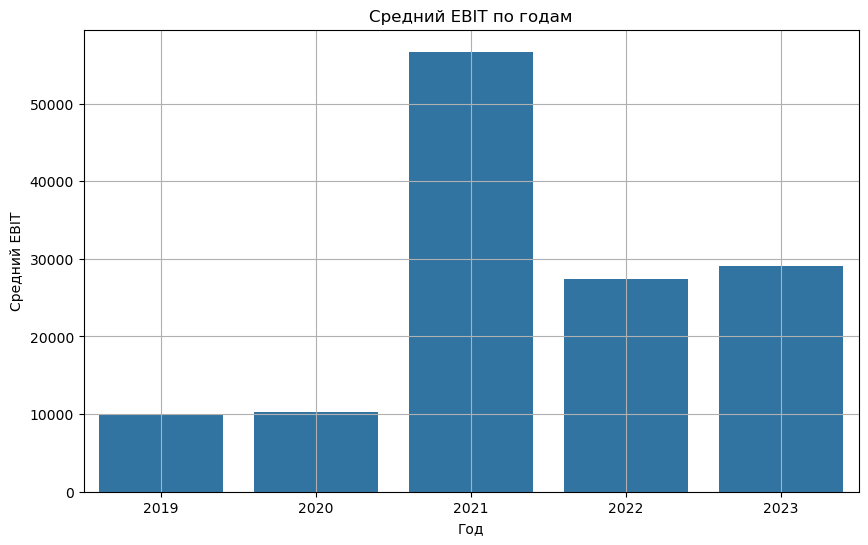

In [174]:
df_grouped = df.groupby('year')['EBIT'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='EBIT', data=df_grouped, ci=None)
plt.title('Средний EBIT по годам')
plt.xlabel('Год')
plt.ylabel('Средний EBIT')
plt.grid(True)
plt.show()

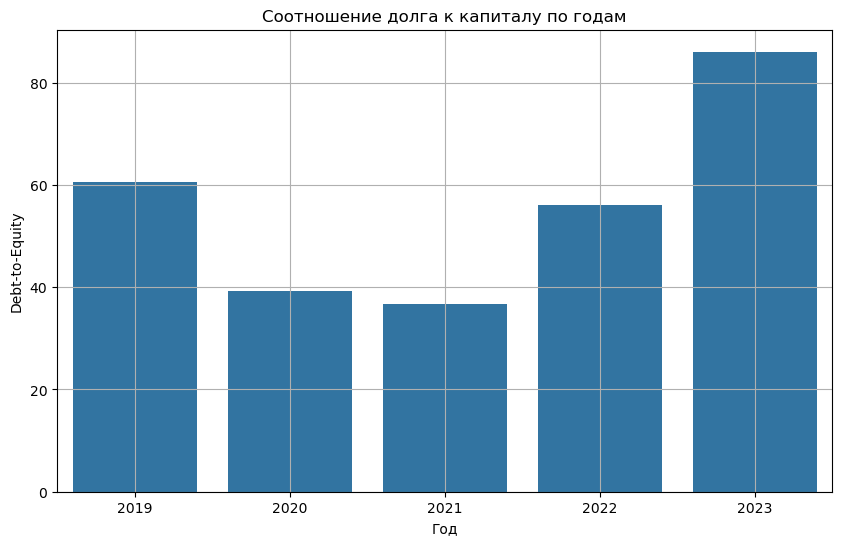

In [175]:
df_grouped = df.groupby('year')['Debt-to-Equity'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='Debt-to-Equity', data=df_grouped, ci=None)
plt.title('Соотношение долга к капиталу по годам')
plt.xlabel('Год')
plt.ylabel('Debt-to-Equity')
plt.grid(True)
plt.show()

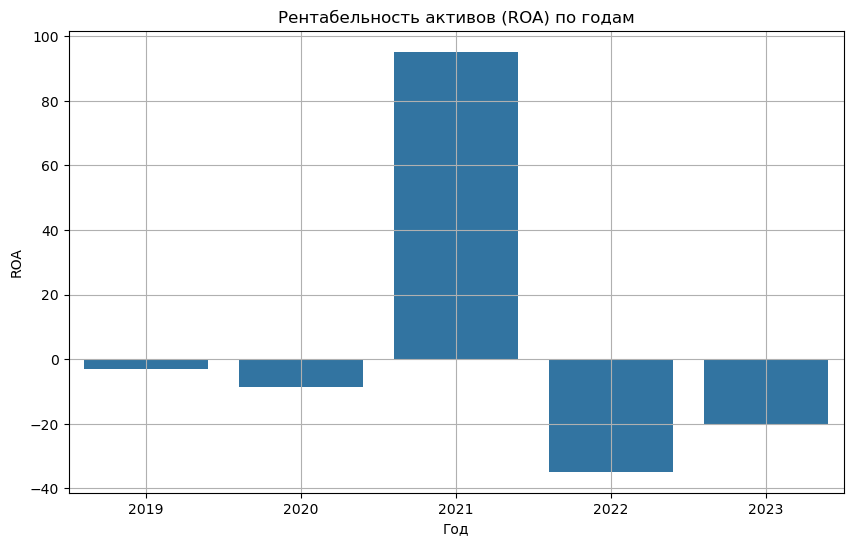

In [176]:
df_grouped = df.groupby('year')['ROA'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='ROA', data=df_grouped, ci=None)
plt.title('Рентабельность активов (ROA) по годам')
plt.xlabel('Год')
plt.ylabel('ROA')
plt.grid(True)
plt.show()

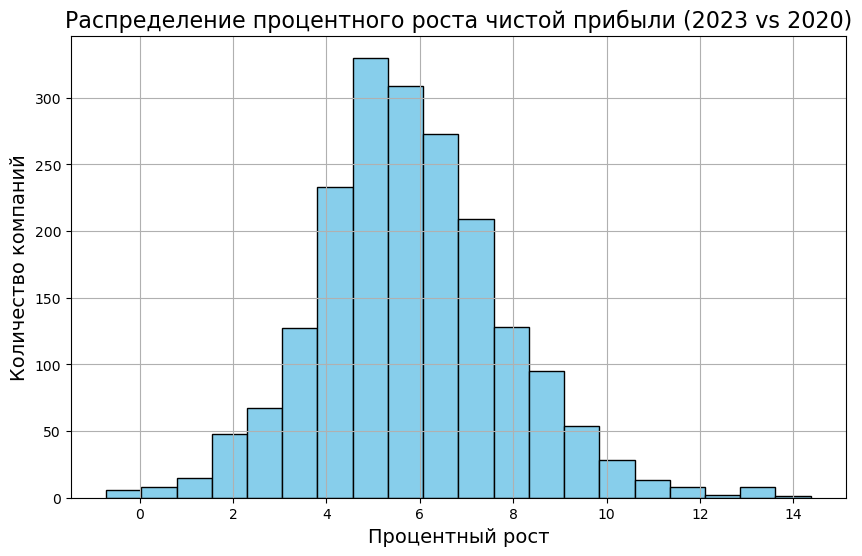

In [177]:
df_filtered = df[df['year'].isin([2020, 2023])]

def calculate_profit_growth(group):
    profit_2023 = group.loc[group['year'] == 2023, 'net profit']
    profit_2020 = group.loc[group['year'] == 2020, 'net profit']
    
    if not profit_2023.empty and not profit_2020.empty:
        profit_2023 = profit_2023.values[0]
        profit_2020 = profit_2020.values[0]
        
        if profit_2020 != 0:
            growth = ((profit_2023 - profit_2020) / profit_2020) * 100
            return pd.Series({'id': group['id'].iloc[0], 'profit_growth_2023_vs_2020': growth})
    
    return None

result = df_filtered.groupby('id').apply(calculate_profit_growth).dropna()
log_data = np.log1p(result['profit_growth_2023_vs_2020'])
plt.figure(figsize=(10, 6))
plt.hist(log_data, bins=20, color='skyblue', edgecolor='black')

plt.title('Распределение процентного роста чистой прибыли (2023 vs 2020)', fontsize=16)
plt.xlabel('Процентный рост', fontsize=14)
plt.ylabel('Количество компаний', fontsize=14)

plt.grid(True)
plt.show()

## Получение координат местоположений

In [102]:
df['latitude']=0
df['longitude']=0
geolocator_arcgis = ArcGIS()

def get_latitude(address):
    try:
        location = geolocator_arcgis.geocode(address)
        if location:
            return location.latitude
        else:
            return None
    except Exception as e:
        print(f"Ошибка для адреса {address}: {e}")
        return None

def get_longitude(address):
    try:
        location = geolocator_arcgis.geocode(address)
        if location:
            return location.longitude
        else:
            return None
    except Exception as e:
        print(f"Ошибка для адреса {address}: {e}")
        return None

f= df['address'][50000:len(df)].apply(get_latitude)
k = df['address'][50000:len(df)].apply(get_longitude)

In [103]:
df['latitude'][50000:len(df)]=f
df['longitude'][50000:len(df)]=k

In [178]:
df2=pd.read_csv('output2.csv')
df2=df2.drop_duplicates()

In [179]:
df2_new=df2[df2['longitude']!=0]
df2_new['income tax']=abs(df2_new['income tax'])
mask=(df2_new['net profit']==0) & (df2_new['interests to pay']==0) & (df2_new['income tax']==0)
mask2=(df2_new['revenue']==0) | (df2_new['capital']==0) | (df2_new['actives']==0)
df2_new=df2_new[~mask]
df2_new=df2_new[~mask2]
df2_new['EBIT']=df2_new['net profit']+df2_new['income tax']+df2_new['interests to pay']
df2_new['obligations']=df2_new['passives']-df2_new['capital']
df2_new['Debt-to-Equity'] = df2_new['passives'] / df2_new['capital']
df2_new['ROA'] = (df2_new['net profit'] / df2_new['actives']) * 100
df_of_top500=df2_new.sort_values(by='revenue',ascending=False)[:500][['latitude','longitude']]
df_of_top500

,latitude,longitude
34848,55.611327,37.287227
17322,56.013839,37.847811
13789,59.891791,30.313369
13788,59.891791,30.313369
12657,55.758385,37.714222
12658,55.758385,37.714222
13805,59.891791,30.313369
2391,55.565933,37.479703
12659,55.758385,37.714222
32841,55.682687,37.551161


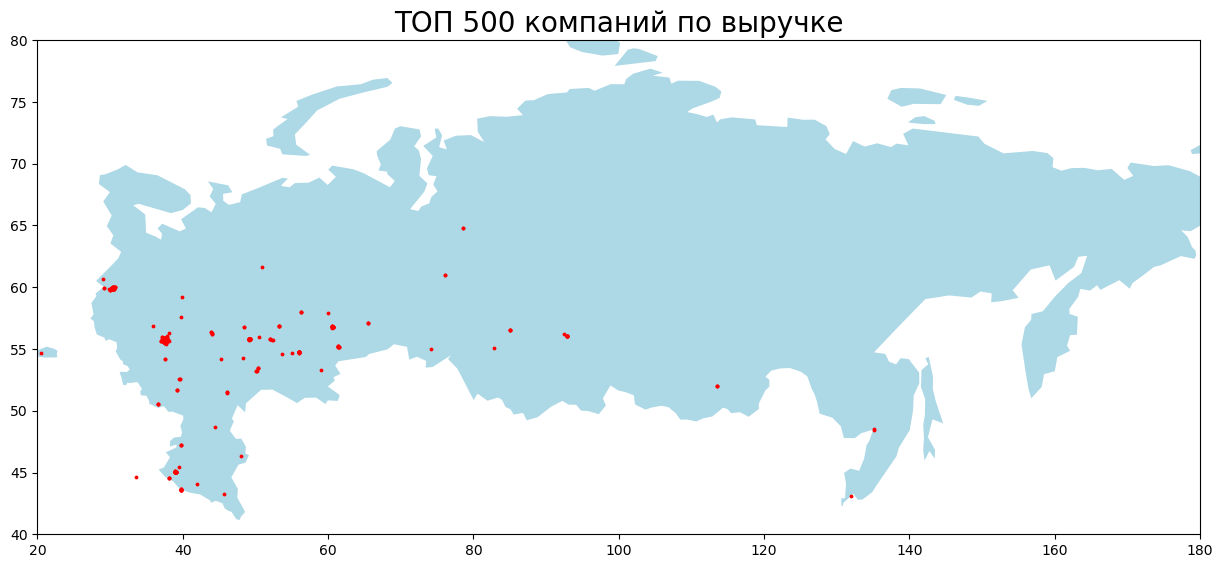

In [180]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
df_of_top500['geometry'] = df_of_top500.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df_of_top500, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

russia = world[world['name'] == 'Russia']

fig, ax = plt.subplots(figsize=(15, 15))  
russia.plot(ax=ax, color='lightblue')

gdf.plot(ax=ax, marker='o', color='red', markersize=3)
ax.set_xlim(20, 180)  
ax.set_ylim(40, 80)   

plt.title("ТОП 500 компаний по выручке", fontsize=20)
plt.show()

## Получение городов для компаний и ещё одного признака

In [154]:
for id in df.id.unique():
    session=requests.Session()
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"
    }
    res=session.get(f"https://bo.nalog.ru/nbo/organizations/{id}/bfo/", headers=headers)
    inn=int(res.json()[0]['organizationInfo']['inn'])
    data[data['ИНН']==inn]

5038038838

In [181]:
pd.set_option('display.max_rows', 10) 

In [192]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")

def get_city(latitude, longitude):
    try:
        location = geolocator.reverse((latitude, longitude), language='en')
        address = location.raw.get('address', {})
        city = address.get('city', address.get('town', address.get('village', 'Unknown')))
        return city
    except:
        return 'Unknown'

df2_new['city'] = df2_new.apply(lambda row: get_city(row['latitude'], row['longitude']), axis=1)

print(df2_new[['latitude', 'longitude', 'city']].head())

    latitude  longitude      city
0  56.008705  37.851908  Pushkino
1  56.008705  37.851908  Pushkino
2  56.008705  37.851908  Pushkino
3  56.008705  37.851908  Pushkino
4  55.993094  37.804641  Pushkino


## A/B тест о влиянии местоположения компании

In [196]:
df2_new.to_csv('output3.csv',index=False)

In [272]:
df3=pd.read_csv('output3.csv')
df3=df3[df3['city']!='Unknown']

In [324]:
large_cities = ['Moscow', 'Saint Petersburg', 'Novosibirsk', 'Yekaterinburg', 'Kazan', 
                'Nizhny Novgorod', 'Krasnodar', 'Krasnoyarsk', 'Perm', 'Ufa', 
                'Chelyabinsk', 'Rostov-on-Don', 'Voronezh', 'Samara', 'Omsk', 'Volgograd']
df3['is_large_city'] = df3['city'].apply(lambda x: 1 if x in large_cities else 0)
metrics = ['EBIT', 'Debt-to-Equity', 'ROA']  
df_grouped = df3.groupby('is_large_city')[metrics].mean().reset_index()
large_city_companies = df3[df3['is_large_city'] == 1]['EBIT']
other_city_companies = df3[df3['is_large_city'] == 0]['EBIT']

Shapiro-Wilk Test: Statistic=0.015262961387634277, p-value=0.0


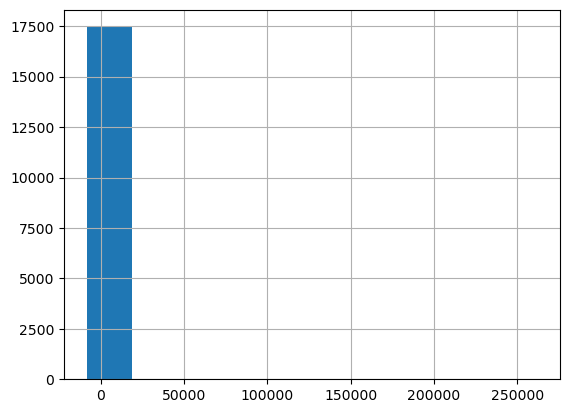

In [274]:
large_city_companies.hist()
shapiro_test = stats.shapiro(large_city_companies)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

In [269]:
u_statistic, p_value_mannwhitney = stats.mannwhitneyu(large_city_companies, other_city_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=171803695.0, p-value=4.208952917577422e-12
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


In [270]:
large_city_companies = df3[df3['is_large_city'] == 'Large City']['ROA']
other_city_companies = df3[df3['is_large_city'] == 'Other City']['ROA']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(large_city_companies, other_city_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=153401578.0, p-value=1.6076913435259883e-30
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


In [271]:
large_city_companies = df3[df3['is_large_city'] == 'Large City']['Debt-to-Equity']
other_city_companies = df3[df3['is_large_city'] == 'Other City']['Debt-to-Equity']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(large_city_companies, other_city_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=189831835.0, p-value=1.3380203518769467e-137
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


In [276]:
mean_lat = df3['latitude'].mean()
mean_lon = df3['longitude'].mean()

df3['region'] = np.where(df3['latitude'] > mean_lat, 'North', 'South')
df3['region'] = np.where(df3['longitude'] > mean_lon, df3['region'] + '_East', df3['region'] + '_West')
df_grouped2 = df3.groupby('region')[['EBIT','ROA', 'Debt-to-Equity']].mean().reset_index()


In [280]:
north_companies = df3[df3['region'].str.contains('North')]['EBIT']
south_companies = df3[df3['region'].str.contains('South')]['EBIT']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(north_companies, south_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=145032180.5, p-value=0.3444016365881154
Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.


In [281]:
north_companies = df3[df3['region'].str.contains('North')]['ROA']
south_companies = df3[df3['region'].str.contains('South')]['ROA']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(north_companies, south_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=141644503.0, p-value=5.399870674028991e-06
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


In [282]:
north_companies = df3[df3['region'].str.contains('North')]['Debt-to-Equity']
south_companies = df3[df3['region'].str.contains('South')]['Debt-to-Equity']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(north_companies, south_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=152871359.0, p-value=1.4440788913291471e-13
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


## Модели для предсказания revenue

In [463]:
df3=df3[df3['revenue']>=0]
X = df3[['actives', 'obligations', 'is_large_city','year','income tax','interests to pay']]
y = df3['revenue']

In [465]:
def remove_outliers_iqr(df):
    df_no_outliers = df.copy()
    
    for col in df_no_outliers.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df_no_outliers[col].quantile(0.2)
        Q3 = df_no_outliers[col].quantile(0.8)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    
    return df_no_outliers

X_no_outliers = remove_outliers_iqr(X)
remaining_indices = X_no_outliers.index

y_no_outliers = y.loc[remaining_indices]

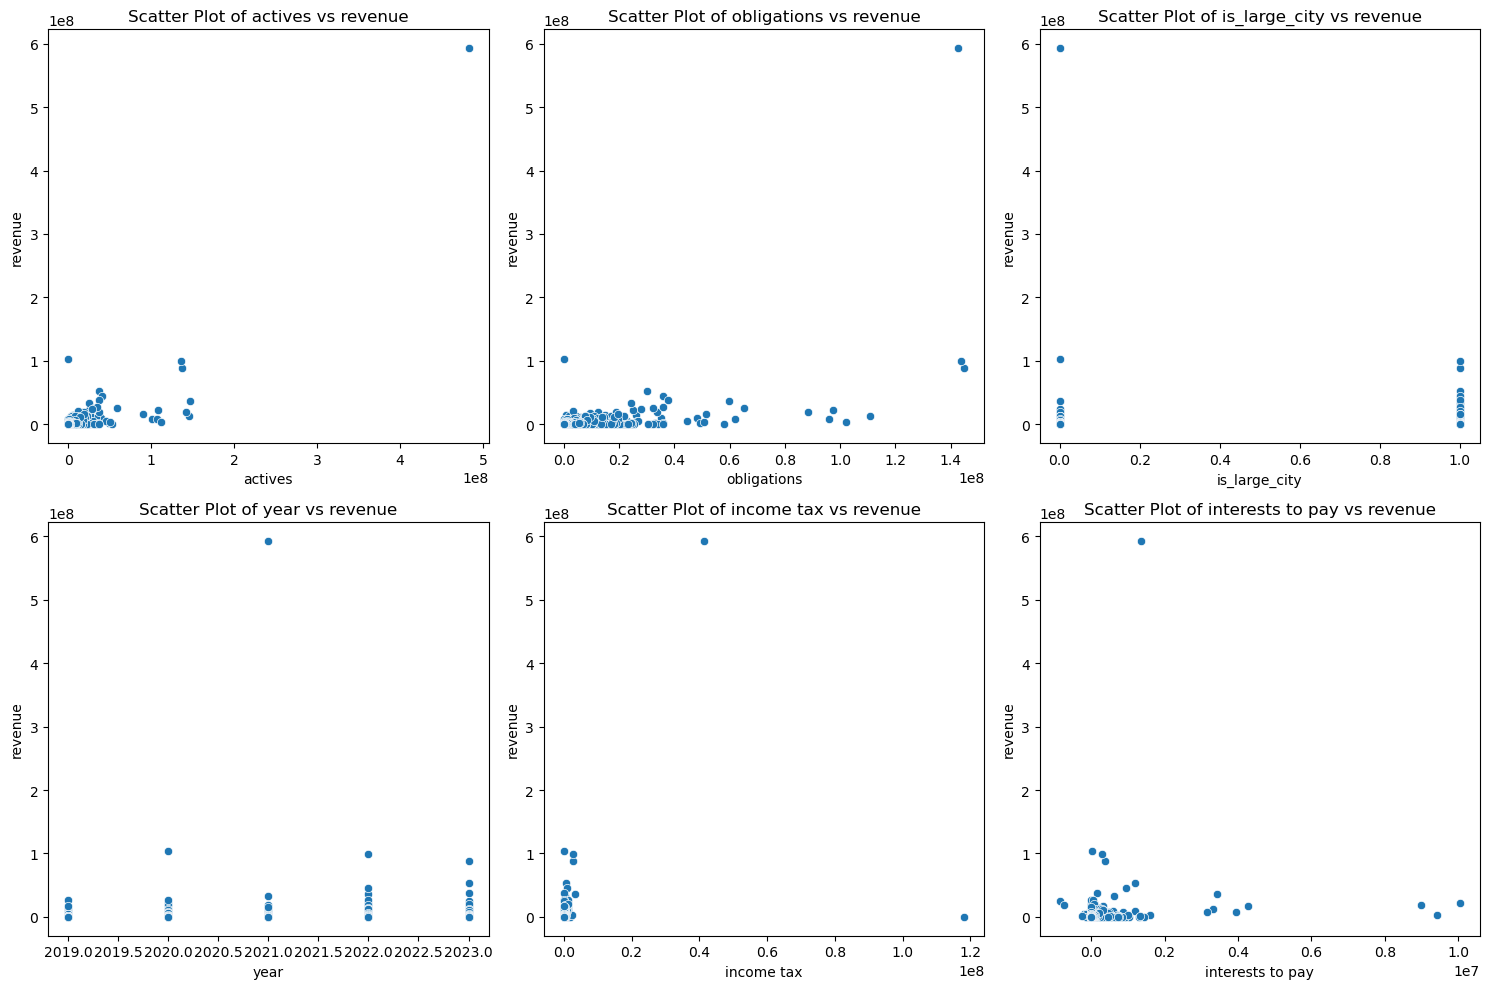

In [466]:
target_column = 'revenue'
features = ['actives', 'obligations', 'is_large_city', 'year', 'income tax', 'interests to pay']
n_features = len(features)

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, (n_features + 1) // 2, i)  
    sns.scatterplot(x=df3[feature], y=df3[target_column])
    plt.title(f'Scatter Plot of {feature} vs {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)

plt.tight_layout()  
plt.show()

In [467]:
X_train, X_test, Y_train, Y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.3)

In [468]:
pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),  
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

pipeline_gb.fit(X_train,Y_train)
y_pred_gb = pipeline_gb.predict(X_test)

mse_gb = mean_squared_error(Y_test, y_pred_gb)
r2_gb = r2_score(Y_test, y_pred_gb)
print(f"Gradient Boosting - Mean Squared Error: {mse_gb}, R2: {r2_gb}")

Gradient Boosting - Mean Squared Error: 5131157001.261919, R2: 0.36689877229658496


In [469]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('lasso', Lasso(alpha=0.1))    
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(Y_test,y_pred)
r2=r2_score(Y_test,y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2: {r2}")

Mean Squared Error: 4816515871.9412775
R2: 0.40572036462164884


In [470]:
from sklearn.preprocessing import PolynomialFeatures

pipeline_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=0.1))
])

pipeline_poly.fit(X_train, Y_train)
y_pred_poly = pipeline_poly.predict(X_test)

mse_poly = mean_squared_error(Y_test, y_pred_poly)
r2_poly = r2_score(Y_test, y_pred_poly)
print(f"Polynomial Ridge - Mean Squared Error: {mse_poly}, R2: {r2_poly}")

Polynomial Ridge - Mean Squared Error: 4588671684.601268, R2: 0.4338326275468667


In [ ]:
#Данные признаки плохо подходят для revenue